In [2]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [ ]:
#creates review_stars.tsv from yelp dataset and rea
import json
import csv
import pandas as pd
outfile = open("review_stars.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'text'])
with open('yelp_academic_dataset_review.json', encoding="utf-8") as f:
 for line in f:
     row = json.loads(line)
     # some special char must be encoded in 'utf-8'
     sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')])

outfile.close()
df= pd.read_csv('review_stars.tsv', delimiter ="\t", encoding="utf-8")
print("done")

Used instead if already created the review_stars.tsv file

In [16]:
#reads review_stars.tsv if already created and stores it as a numpy array
import json
import csv
import pandas as pd
df= pd.read_csv('review_stars.tsv', delimiter ="\t", encoding="utf-8")
print("done")
df

done


,business_id,stars,text
0,-MhfebM0QIsKt87iDN-FNw,2.0,"b'As someone who has worked with many museums,..."
1,lbrU8StCq3yDfr-QMnGrmQ,1.0,b'I am actually horrified this place is still ...
2,HQl28KMwrEKHqhFrrDqVNQ,5.0,"b""I love Deagan's. I do. I really do. The atmo..."
3,5JxlZaqCnk1MnbgRirs40Q,1.0,"b'Dismal, lukewarm, defrosted-tasting ""TexMex""..."
4,IS4cv902ykd8wj1TR0N3-A,4.0,"b'Oh happy day, finally have a Canes near my c..."
...,...,...,...
8021117,XW2kaXdahICaJ27A0dhGHg,1.0,"b""Fricken unbelievable, I ordered 2 space heat..."
8021118,IsoLzudHC50oJLiEWpwV-w,3.0,"b""Solid American food with a southern comfort ..."
8021119,kDCyqlYcstqnoqnfBRS5Og,5.0,"b""I'm honestly not sure how I have never been ..."
8021120,VKVDDHKtsdrnigeIf9S8RA,3.0,"b""Food was decent but I will say the service t..."


In [17]:
#aggregates the reviews into one text
df_review_agg = df.groupby('business_id')['text'].sum() 
print("done")

done


In [18]:
#
df_ready_for_sklearn = pd.DataFrame({'business_id': df_review_agg.index, 'all_reviews':df_review_agg.values})
df_ready_for_sklearn.head()

,business_id,all_reviews
0,--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...
1,--6MefnULPED_I942VcFNA,"b""The bbq pork is very juicy and I only come h..."
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r..."
3,--8LPVSo5i0Oo61X01sV9A,b'Dr. LaCognata is great. He is a great liste...
4,--9QQLMTbFzLJ_oT-ON3Xw,b'Always great customer service. Affordable ha...


In [19]:
df_ready_for_sklearn

,business_id,all_reviews
0,--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...
1,--6MefnULPED_I942VcFNA,"b""The bbq pork is very juicy and I only come h..."
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r..."
3,--8LPVSo5i0Oo61X01sV9A,b'Dr. LaCognata is great. He is a great liste...
4,--9QQLMTbFzLJ_oT-ON3Xw,b'Always great customer service. Affordable ha...
...,...,...
209388,zzvlwkcNR1CCqOPXwuvz2A,"b""I came here on a Friday night looking for a ..."
209389,zzwaS0xn1MVEPEf0hNLjew,"b'Though, I never had a friend with a grandma ..."
209390,zzwhN7x37nyjP0ZM8oiHmw,b'This place is a hidden gem! The pickle fries...
209391,zzwicjPC9g246MK2M1ZFBA,b'Food not good no selection..bad service +Qat...


In [19]:
import json
import csv
import pandas as pd
outfile = open("business_name.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id', 'name', 'review_count', 'stars'])
with open('yelp_academic_dataset_business.json', encoding="utf-8") as f:
 for line in f:
     row = json.loads(line)
     # some special char must be encoded in 'utf-8'
     sfile.writerow([row['business_id'], row['name'].encode('utf-8'), row['review_count'], row['stars']])

outfile.close()
df_for_businesses= pd.read_csv('business_name.tsv', delimiter ="\t", encoding="utf-8")
print("done")

done


Used instead if already created the busniess_name.tsv file

In [20]:
import json
import csv
import pandas as pd
df_for_businesses= pd.read_csv('business_name.tsv', delimiter ="\t", encoding="utf-8")
print("done")

done


In [22]:
#ready the code to be put into tfidf format
df = pd.merge(df_ready_for_sklearn, df_for_businesses, on='business_id')
df = df[df['review_count'] >= 20]
df = df.reset_index(drop=True)
df.to_csv('combined_dataset.tsv', sep='\t', index=False)


In [43]:
df = pd.read_csv('combined_dataset.tsv', delimiter = '\t')
df

,business_id,all_reviews,name,review_count,stars
0,--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...,b'The Spicy Amigos',27,4.0
1,--6MefnULPED_I942VcFNA,"b""The bbq pork is very juicy and I only come h...","b""John's Chinese BBQ Restaurant""",55,3.0
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r...",b'Primal Brewery',65,4.0
3,--9e1ONYQuAa-CB_Rrw7Tw,"b""On yelp 5 stars = Woohoo! as good as it gets...",b'Delmonico Steakhouse',1759,4.0
4,--DaPTJW3-tB1vP-PfdTEg,"b""I used to come to this restaurant about two ...",b'Sunnyside Grill',51,4.0
...,...,...,...,...,...
66112,zzsOLFhgUw8gnjLTVVItFA,"b""I'm usually not a big fan of Mexican pastrie...",b'La Purisima Bakery',138,4.5
66113,zzwaS0xn1MVEPEf0hNLjew,"b'Though, I never had a friend with a grandma ...",b'Dilly Dally Lounge',73,3.5
66114,zzwhN7x37nyjP0ZM8oiHmw,b'This place is a hidden gem! The pickle fries...,"b""Carmody's Grille""",75,4.0
66115,zzwicjPC9g246MK2M1ZFBA,b'Food not good no selection..bad service +Qat...,b'Sizzler',81,3.0


In [27]:
df

,business_id,all_reviews,name,review_count,stars
0,--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...,b'The Spicy Amigos',27,4.0
1,--6MefnULPED_I942VcFNA,"b""The bbq pork is very juicy and I only come h...","b""John's Chinese BBQ Restaurant""",55,3.0
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r...",b'Primal Brewery',65,4.0
3,--9e1ONYQuAa-CB_Rrw7Tw,"b""On yelp 5 stars = Woohoo! as good as it gets...",b'Delmonico Steakhouse',1759,4.0
4,--DaPTJW3-tB1vP-PfdTEg,"b""I used to come to this restaurant about two ...",b'Sunnyside Grill',51,4.0
...,...,...,...,...,...
66112,zzsOLFhgUw8gnjLTVVItFA,"b""I'm usually not a big fan of Mexican pastrie...",b'La Purisima Bakery',138,4.5
66113,zzwaS0xn1MVEPEf0hNLjew,"b'Though, I never had a friend with a grandma ...",b'Dilly Dally Lounge',73,3.5
66114,zzwhN7x37nyjP0ZM8oiHmw,b'This place is a hidden gem! The pickle fries...,"b""Carmody's Grille""",75,4.0
66115,zzwicjPC9g246MK2M1ZFBA,b'Food not good no selection..bad service +Qat...,b'Sizzler',81,3.0


In [44]:
import sklearn.feature_extraction.text as sk_text

vectorizer = sk_text.TfidfVectorizer(
                             stop_words='english',
                             max_features = 100,
                             min_df= 2,
                             max_df= 0.95
                                    )

matrix = vectorizer.fit_transform(df['all_reviews'])

#matrix_df = pd.DataFrame(matrix.todense(), columns=vectorizer.get_feature_names())
matrix_df = pd.DataFrame(matrix.todense())

tfidf_df = pd.merge(df, matrix_df,right_index=True,left_index=True)

In [45]:
tfidf_df

,business_id,all_reviews,name,review_count,stars,0,1,2,3,4,...,90,91,92,93,94,95,96,97,98,99
0,--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...,b'The Spicy Amigos',27,4.0,0.021692,0.042894,0.000000,0.000000,0.029922,...,0.000000,0.000000,0.021839,0.121766,0.000000,0.021455,0.021262,0.068603,0.034636,0.022960
1,--6MefnULPED_I942VcFNA,"b""The bbq pork is very juicy and I only come h...","b""John's Chinese BBQ Restaurant""",55,3.0,0.035728,0.017662,0.089232,0.070330,0.012321,...,0.000000,0.067068,0.062946,0.100276,0.044586,0.026503,0.008755,0.056495,0.000000,0.113448
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r...",b'Primal Brewery',65,4.0,0.038905,0.025643,0.272068,0.051056,0.286213,...,0.000000,0.083465,0.065280,0.048530,0.012947,0.025653,0.025422,0.027342,0.000000,0.027453
3,--9e1ONYQuAa-CB_Rrw7Tw,"b""On yelp 5 stars = Woohoo! as good as it gets...",b'Delmonico Steakhouse',1759,4.0,0.026748,0.120327,0.023515,0.045019,0.050178,...,0.441602,0.037587,0.046587,0.048046,0.048333,0.063493,0.014682,0.071339,0.104635,0.036805
4,--DaPTJW3-tB1vP-PfdTEg,"b""I used to come to this restaurant about two ...",b'Sunnyside Grill',51,4.0,0.069586,0.041280,0.055615,0.027396,0.019197,...,0.000000,0.044787,0.084068,0.078122,0.041683,0.096356,0.013641,0.014671,0.022222,0.014731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66112,zzsOLFhgUw8gnjLTVVItFA,"b""I'm usually not a big fan of Mexican pastrie...",b'La Purisima Bakery',138,4.5,0.057614,0.206490,0.057558,0.014177,0.000000,...,0.000000,0.077252,0.166760,0.080852,0.079088,0.014246,0.049412,0.159432,0.080493,0.076227
66113,zzwaS0xn1MVEPEf0hNLjew,"b'Though, I never had a friend with a grandma ...",b'Dilly Dally Lounge',73,3.5,0.018453,0.012163,0.018435,0.018163,0.076363,...,0.000000,0.006598,0.018578,0.046038,0.024564,0.036503,0.018087,0.012969,0.000000,0.045575
66114,zzwhN7x37nyjP0ZM8oiHmw,b'This place is a hidden gem! The pickle fries...,"b""Carmody's Grille""",75,4.0,0.022406,0.044305,0.119381,0.051457,0.113323,...,0.000000,0.040057,0.045114,0.055898,0.014912,0.044322,0.036602,0.023620,0.023850,0.039526
66115,zzwicjPC9g246MK2M1ZFBA,b'Food not good no selection..bad service +Qat...,b'Sizzler',81,3.0,0.034482,0.015496,0.021922,0.024683,0.008648,...,0.000000,0.013450,0.006312,0.023462,0.015648,0.006201,0.012290,0.023132,0.015016,0.039816


In [47]:
tfidf_df.drop('business_id', 1, inplace=True)
tfidf_df.drop('all_reviews', 1, inplace=True)
tfidf_df.drop('name', 1, inplace=True)
tfidf_df.drop('review_count', 1, inplace=True)

In [48]:
tfidf_df.to_csv('tfidf_dataset.tsv', sep='\t', index=False)

Use instead if already created tfidf_dataset.tsv

In [ ]:
import json
import csv
import pandas as pd
tfidf_df = pd.read_csv('tfidf_dataset.tsv', delimiter ="\t", encoding="utf-8")
print("done")

In [49]:
tfidf_df

,stars,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,4.0,0.021692,0.042894,0.000000,0.000000,0.029922,0.000000,0.000000,0.063899,0.032932,...,0.000000,0.000000,0.021839,0.121766,0.000000,0.021455,0.021262,0.068603,0.034636,0.022960
1,3.0,0.035728,0.017662,0.089232,0.070330,0.012321,0.008920,0.000000,0.043851,0.000000,...,0.000000,0.067068,0.062946,0.100276,0.044586,0.026503,0.008755,0.056495,0.000000,0.113448
2,4.0,0.038905,0.025643,0.272068,0.051056,0.286213,0.025901,0.175479,0.038200,0.393753,...,0.000000,0.083465,0.065280,0.048530,0.012947,0.025653,0.025422,0.027342,0.000000,0.027453
3,4.0,0.026748,0.120327,0.023515,0.045019,0.050178,0.034191,0.038978,0.040708,0.066189,...,0.441602,0.037587,0.046587,0.048046,0.048333,0.063493,0.014682,0.071339,0.104635,0.036805
4,4.0,0.069586,0.041280,0.055615,0.027396,0.019197,0.027797,0.028972,0.040996,0.000000,...,0.000000,0.044787,0.084068,0.078122,0.041683,0.096356,0.013641,0.014671,0.022222,0.014731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66112,4.5,0.057614,0.206490,0.057558,0.014177,0.000000,0.028768,0.059970,0.042428,0.000000,...,0.000000,0.077252,0.166760,0.080852,0.079088,0.014246,0.049412,0.159432,0.080493,0.076227
66113,3.5,0.018453,0.012163,0.018435,0.018163,0.076363,0.018428,0.025610,0.024159,0.821769,...,0.000000,0.006598,0.018578,0.046038,0.024564,0.036503,0.018087,0.012969,0.000000,0.045575
66114,4.0,0.022406,0.044305,0.119381,0.051457,0.113323,0.037292,0.101061,0.029333,0.317474,...,0.000000,0.040057,0.045114,0.055898,0.014912,0.044322,0.036602,0.023620,0.023850,0.039526
66115,3.0,0.034482,0.015496,0.021922,0.024683,0.008648,0.028174,0.009789,0.043092,0.533004,...,0.000000,0.013450,0.006312,0.023462,0.015648,0.006201,0.012290,0.023132,0.015016,0.039816


In [74]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split

from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

#path = "./"

#filename = os.path.join(path, 'tfidf_dataset.csv')
df = pd.read_csv('tfidf_dataset.tsv', delimiter = '\t')

#stars = encode_text_index(tfidf_df,"stars")

x,y = to_xy(df,"stars")

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

model = Sequential()

model.add(Dense(10, input_dim=x.shape[1], activation='tanh'))
model.add(Dense(10))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  

model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=100)  

#pred = model.predict(x)
#print(pred)

Train on 49587 samples, validate on 16530 samples
Epoch 1/100
49587/49587 - 2s - loss: 0.4914 - val_loss: 0.2023
Epoch 2/100
49587/49587 - 2s - loss: 0.1930 - val_loss: 0.1914
Epoch 3/100
49587/49587 - 2s - loss: 0.1793 - val_loss: 0.1715
Epoch 4/100
49587/49587 - 2s - loss: 0.1644 - val_loss: 0.1582
Epoch 5/100
49587/49587 - 2s - loss: 0.1559 - val_loss: 0.1615
Epoch 6/100
49587/49587 - 2s - loss: 0.1513 - val_loss: 0.1507
Epoch 7/100
49587/49587 - 2s - loss: 0.1483 - val_loss: 0.1496
Epoch 8/100
49587/49587 - 2s - loss: 0.1467 - val_loss: 0.1624
Epoch 9/100
49587/49587 - 2s - loss: 0.1445 - val_loss: 0.1464
Epoch 10/100
49587/49587 - 2s - loss: 0.1429 - val_loss: 0.1435
Epoch 11/100
49587/49587 - 2s - loss: 0.1414 - val_loss: 0.1432
Epoch 12/100
49587/49587 - 2s - loss: 0.1405 - val_loss: 0.1430
Epoch 00012: early stopping


In [77]:
pred = model.predict(x_test)
print(pred)

[[4.833986 ]
 [4.058045 ]
 [3.547628 ]
 ...
 [3.900684 ]
 [3.353561 ]
 [4.0777993]]


In [78]:
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

Score (RMSE): 0.37811630964279175


In [79]:
df_y = pd.DataFrame(y_test, columns=['ground_truth'])
df_pred = pd.DataFrame(pred, columns=['predicted'])
result = pd.concat([df_y, df_pred],axis=1)
result

,ground_truth,predicted
0,5.0,4.833986
1,4.0,4.058045
2,3.5,3.547628
3,2.5,2.802534
4,4.0,4.189836
...,...,...
16525,3.5,3.526448
16526,4.5,4.459370
16527,3.5,3.900684
16528,3.0,3.353561


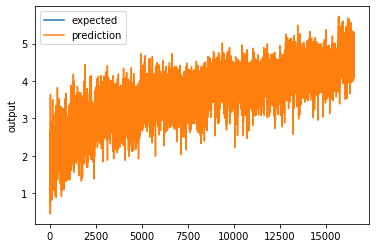

In [80]:
chart_regression(pred.flatten(),y_test, sort=True)

In [4]:
import json
import csv
import pandas as pd
df= pd.read_csv('tfidf_dataset.tsv', delimiter ="\t", encoding="utf-8")
print("done")
df

done


,stars,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,4.0,0.021692,0.042894,0.000000,0.000000,0.029922,0.000000,0.000000,0.063899,0.032932,...,0.000000,0.000000,0.021839,0.121766,0.000000,0.021455,0.021262,0.068603,0.034636,0.022960
1,3.0,0.035728,0.017662,0.089232,0.070330,0.012321,0.008920,0.000000,0.043851,0.000000,...,0.000000,0.067068,0.062946,0.100276,0.044586,0.026503,0.008755,0.056495,0.000000,0.113448
2,4.0,0.038905,0.025643,0.272068,0.051056,0.286213,0.025901,0.175479,0.038200,0.393753,...,0.000000,0.083465,0.065280,0.048530,0.012947,0.025653,0.025422,0.027342,0.000000,0.027453
3,4.0,0.026748,0.120327,0.023515,0.045019,0.050178,0.034191,0.038978,0.040708,0.066189,...,0.441602,0.037587,0.046587,0.048046,0.048333,0.063493,0.014682,0.071339,0.104635,0.036805
4,4.0,0.069586,0.041280,0.055615,0.027396,0.019197,0.027797,0.028972,0.040996,0.000000,...,0.000000,0.044787,0.084068,0.078122,0.041683,0.096356,0.013641,0.014671,0.022222,0.014731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66112,4.5,0.057614,0.206490,0.057558,0.014177,0.000000,0.028768,0.059970,0.042428,0.000000,...,0.000000,0.077252,0.166760,0.080852,0.079088,0.014246,0.049412,0.159432,0.080493,0.076227
66113,3.5,0.018453,0.012163,0.018435,0.018163,0.076363,0.018428,0.025610,0.024159,0.821769,...,0.000000,0.006598,0.018578,0.046038,0.024564,0.036503,0.018087,0.012969,0.000000,0.045575
66114,4.0,0.022406,0.044305,0.119381,0.051457,0.113323,0.037292,0.101061,0.029333,0.317474,...,0.000000,0.040057,0.045114,0.055898,0.014912,0.044322,0.036602,0.023620,0.023850,0.039526
66115,3.0,0.034482,0.015496,0.021922,0.024683,0.008648,0.028174,0.009789,0.043092,0.533004,...,0.000000,0.013450,0.006312,0.023462,0.015648,0.006201,0.012290,0.023132,0.015016,0.039816
